In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge, ElasticNet
pd.set_option('display.max_columns', 500)

# Load the dataset
Ames = pd.read_csv('~/Documents/NYCDSA/Third Project/ML_Ames_Housing/data/Ames_Housing_Price_Data.csv', index_col=0)
Ames = Ames.drop(columns=['PID'])
# Convert the below numeric features to categorical features
Ames['YrSold'] = Ames['YrSold'].astype('object')
Ames['MoSold'] = Ames['MoSold'].astype('object')
Ames['YearRemodAdd'] = Ames['YearRemodAdd'].astype('object')
Ames['GarageYrBlt'] = Ames['GarageYrBlt'].astype('str')
Ames['YearBuilt'] = Ames['YearBuilt'].astype('object')
Ames['MSSubClass'] = Ames['MSSubClass'].astype('object')

# Exclude 'PID' and 'SalePrice' from features and specifically handle the 'Electrical' column
numeric_features = Ames.select_dtypes(include=['int64', 'float64']).drop(columns=['SalePrice','BsmtFinSF2', 'BsmtUnfSF', 'BsmtFinSF1','1stFlrSF', '2ndFlrSF', 'LowQualFinSF']).columns
categorical_features = Ames.select_dtypes(include=['object']).columns.difference(['Electrical'])
electrical_feature = ['Electrical']

In [3]:
ordinal_order = {
    'Electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr']
}

# Helper function to fill 'None' for missing categorical data
def fill_none(X):
    return X.fillna("None")

# Pipeline for 'Electrical': Fill missing value with mode then apply ordinal encoding
electrical_transformer = Pipeline(steps=[
    ('impute_electrical', SimpleImputer(strategy='most_frequent')),
    (('ordinal_electrical', OrdinalEncoder(categories=[ordinal_order['Electrical']]))),
])

numeric_transformer = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
])

# Pipeline for nominal categorical features: Fill missing values with 'None' then apply one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('impute_none', SimpleImputer(strategy='constant', fill_value='None')),  # Using SimpleImputer
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop = 'first'))
])

# Combined preprocessor for numeric, ordinal, nominal, and specific electrical data
preprocessor = ColumnTransformer(
    transformers=[
        ('electrical', electrical_transformer, ['Electrical']),
        ('num', numeric_transformer, numeric_features),
        ('nominal', categorical_transformer, categorical_features)
])

In [4]:
# Apply the preprocessing pipeline to Ames
transformed_data = preprocessor.fit_transform(Ames)

# Generate column names for the one-hot encoded features
onehot_features = preprocessor.named_transformers_['nominal'].named_steps['onehot'].get_feature_names_out()
all_feature_names = ['Electrical'] + list(numeric_features) + list(onehot_features)
 # Convert the transformed array to a DataFrame
transformed_df = pd.DataFrame(transformed_data.toarray(), columns=all_feature_names)
transformed_df

,Electrical,GrLivArea,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,x0_None,x0_Pave,x1_2fmCon,x1_Duplex,x1_Twnhs,x1_TwnhsE,x2_Fa,x2_Gd,x2_None,x2_Po,x2_TA,x3_Gd,x3_Mn,x3_No,x3_None,x4_BLQ,x4_GLQ,x4_LwQ,x4_None,x4_Rec,x4_Unf,x5_BLQ,x5_GLQ,x5_LwQ,x5_None,x5_Rec,x5_Unf,x6_Fa,x6_Gd,x6_None,x6_Po,x6_TA,x7_Y,x8_Feedr,x8_Norm,x8_PosA,x8_PosN,x8_RRAe,x8_RRAn,x8_RRNe,x8_RRNn,x9_Feedr,x9_Norm,x9_PosA,x9_PosN,x9_RRAe,x9_RRAn,x9_RRNn,x10_Fa,x10_Gd,x10_Po,x10_TA,x11_Fa,x11_Gd,x11_TA,x12_AsphShn,x12_BrkComm,x12_BrkFace,x12_CBlock,x12_CemntBd,x12_HdBoard,x12_ImStucc,x12_MetalSd,x12_Plywood,x12_PreCast,x12_Stucco,x12_VinylSd,x12_Wd Sdng,x12_WdShing,x13_AsphShn,x13_Brk Cmn,x13_BrkFace,x13_CBlock,x13_CmentBd,x13_HdBoard,x13_ImStucc,x13_MetalSd,x13_Plywood,x13_PreCast,x13_Stone,x13_Stucco,x13_VinylSd,x13_Wd Sdng,x13_Wd Shng,x14_GdWo,x14_MnPrv,x14_MnWw,x14_None,x15_Fa,x15_Gd,x15_None,x15_Po,x15_TA,x16_CBlock,x16_PConc,x16_Slab,x16_Stone,x16_Wood,x17_Maj2,x17_Min1,x17_Min2,x17_Mod,x17_Sal,x17_Typ,x18_Fa,x18_Gd,x18_None,x18_Po,x18_TA,x19_None,x19_RFn,x19_Unf,x20_Fa,x20_Gd,x20_None,x20_Po,x20_TA,x21_Attchd,x21_Basment,x21_BuiltIn,x21_CarPort,x21_Detchd,x21_None,x22_1900.0,x22_1906.0,x22_1908.0,x22_1910.0,x22_1914.0,x22_1915.0,x22_1916.0,x22_1917.0,x22_1918.0,x22_1920.0,x22_1921.0,x22_1922.0,x22_1923.0,x22_1924.0,x22_1925.0,x22_1926.0,x22_1927.0,x22_1928.0,x22_1929.0,x22_1930.0,x22_1931.0,x22_1932.0,x22_1933.0,x22_1934.0,x22_1935.0,x22_1936.0,x22_1937.0,x22_1938.0,x22_1939.0,x22_1940.0,x22_1941.0,x22_1942.0,x22_1943.0,x22_1945.0,x22_1946.0,x22_1947.0,x22_1948.0,x22_1949.0,x22_1950.0,x22_1951.0,x22_1952.0,x22_1953.0,x22_1954.0,x22_1955.0,x22_1956.0,x22_1957.0,x22_1958.0,x22_1959.0,x22_1960.0,x22_1961.0,x22_1962.0,x22_1963.0,x22_1964.0,x22_1965.0,x22_1966.0,x22_1967.0,x22_1968.0,x22_1969.0,x22_1970.0,x22_1971.0,x22_1972.0,x22_1973.0,x22_1974.0,x22_1975.0,x22_1976.0,x22_1977.0,x22_1978.0,x22_1979.0,x22_1980.0,x22_1981.0,x22_1982.0,x22_1983.0,x22_1984.0,x22_1985.0,x22_1986.0,x22_1987.0,x22_1988.0,x22_1989.0,x22_1990.0,x22_1991.0,x22_1992.0,x22_1993.0,x22_1994.0,x22_1995.0,x22_1996.0,x22_1997.0,x22_1998.0,x22_1999.0,x22_2000.0,x22_2001.0,x22_2002.0,x22_2003.0,x22_2004.0,x22_2005.0,x22_2006.0,x22_2007.0,x22_2008.0,x22_2009.0,x22_2010.0,x22_nan,x23_GasA,x23_GasW,...,x34_Shed,x34_TenC,x35_2,x35_3,x35_4,x35_5,x35_6,x35_7,x35_8,x35_9,x35_10,x35_11,x35_12,x36_Blueste,x36_BrDale,x36_BrkSide,x36_ClearCr,x36_CollgCr,x36_Crawfor,x36_Edwards,x36_Gilbert,x36_Greens,x36_GrnHill,x36_IDOTRR,x36_Landmrk,x36_MeadowV,x36_Mitchel,x36_NAmes,x36_NPkVill,x36_NWAmes,x36_NoRidge,x36_NridgHt,x36_OldTown,x36_SWISU,x36_Sawyer,x36_SawyerW,x36_Somerst,x36_StoneBr,x36_Timber,x36_Veenker,x37_P,x37_Y,x38_Fa,x38_Gd,x38_None,x38_TA,x39_Membran,x39_Metal,x39_Roll,x39_Tar&Grv,x39_WdShake,x39_WdShngl,x40_Gable,x40_Gambrel,x40_Hip,x40_Mansard,x40_Shed,x41_AdjLand,x41_Alloca,x41_Family,x41_Normal,x41_Partial,x42_CWD,x42_Con,x42_ConLD,x42_ConLI,x42_ConLw,x42_New,x42_Oth,x42_VWD,x42_WD,x43_Pave,x44_NoSewr,x45_1875,x45_1879,x45_1880,x45_1882,x45_1885,x45_1890,x45_1892,x45_1893,x45_1895,x45_1898,x45_1900,x45_1902,x45_1904,x45_1905,x45_1906,x45_1908,x45_1910,x45_1912,x45_1913,x45_1914,x45_1915,x45_1916,x45_1917,x45_1918,x45_1919,x45_1920,x45_1921,x45_1922,x45_1923,x45_1924,x45_1925,x45_1926,x45_1927,x45_1928,x45_1929,x45_1930,x45_1931,x45_1932,x45_1934,x45_1935,x45_1936,x45_1937,x45_1938,x45_1939,x45_1940,x45_1941,x45_1942,x45_1945,x45_1946,x45_1947,x45_1948,x45_1949,x45_1950,x45_1951,x45_1952,x45_1953,x45_1954,x45_1955,x45_1956,x45_1957,x45_1958,x45_1959,x45_1960,x45_1961,x45_1962,x45_1963,x45_1964,x45_1965,x45_1966,x45_1967,x45_1968,x45_1969,x45_1970,x45_1971,x45_1972,x45_1973,x45_1974,x45_1975,x45_1976,x45_1977,x45_1978,x45_1979,x45_1980,x45_1981,x45_1982,x45_1983,x45_1984,x45_1985,x45_

In [5]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Target variable
y = Ames['SalePrice']
# All features
X = Ames.drop(columns='SalePrice')
models = LinearRegression()

coefficients_list = []
intercepts_list = []
scores = []
# Perform the KFold cross-validation
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', models)
])
# Initialize the linear regression model
# Fit the model on the training data

In [6]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
scores = cross_val_score(pipeline, Ames.drop(columns='SalePrice'), Ames['SalePrice'], scoring = 'r2', cv=kf, n_jobs = -1)

In [7]:
scores

array([0.90162175, 0.804561  , 0.9132527 , 0.92005806, 0.920804  ,
       0.9072554 , 0.92354157, 0.89611403, 0.90402013, 0.91113725])

In [8]:
fold_scores = []
fold_num = 1
for train_index, test_index in kf.split(Ames):
    X_train, X_test = Ames.drop(columns='SalePrice').iloc[train_index], Ames.drop(columns='SalePrice').iloc[test_index]
    y_train, y_test = Ames['SalePrice'].iloc[train_index], Ames['SalePrice'].iloc[test_index]
    pipeline.fit(X_train, y_train)
    fold_score = pipeline.score(X_test, y_test)
    print(f'Score for Fold: {fold_num}', fold_score)
    fold_scores.append({
        'score':fold_score,
        'fold':fold_num})
    fold_num += 1

C:\Users\immed\Programming\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [12, 17, 22, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\immed\Programming\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [22, 45] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\immed\Programming\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [22, 34, 42] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Score for Fold: 1 0.9016217542885522
Score for Fold: 2 0.804560999047122
Score for Fold: 3 0.9132527010770568


C:\Users\immed\Programming\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [24, 39] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\immed\Programming\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [36] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\immed\Programming\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [22, 39, 45] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Score for Fold: 4 0.9200580568983998
Score for Fold: 5 0.9208039988407078
Score for Fold: 6 0.9072553979671532


C:\Users\immed\Programming\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [9, 10, 22, 45] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\immed\Programming\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [22, 45] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\immed\Programming\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [9, 12, 23, 31, 32, 45] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Score for Fold: 7 0.9235415742091843
Score for Fold: 8 0.8961140344074487
Score for Fold: 9 0.9040201314986298
Score for Fold: 10 0.911137247940496


C:\Users\immed\Programming\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [12, 13, 45] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [9]:
# pipeline.fit(X, y)
# # Store coefficients and intercepts
# coefficients_list.append(pipeline.named_steps['regressor'].coef_)
# intercepts_list.append(pipeline.named_steps['regressor'].intercept_)
# # Evaluate the model
# scores.append(pipeline.score(X, y))
# # Calculate the mean of scores, coefficients, and intercepts
# average_score = np.mean(scores)
# average_coefficients = np.mean(coefficients_list, axis=0)
# # Display the average R² score across all folds
# print(f"Mean CV R² Score of Combined Model: {average_score:.4f}")
# mean_intercept = np.mean(intercepts_list)
# print(f"Mean Y-intercept = {mean_intercept:.0f}")

#This is the entire data set, not being split, being trained and having the entire data set being tested. 

In [10]:
pd.set_option('display.max_rows', 500)
scores = []
coefficients_list = []
fold_num = 1
for train_index, test_index in kf.split(Ames):
    X_train, X_test = Ames.drop(columns='SalePrice').iloc[train_index], Ames.drop(columns='SalePrice').iloc[test_index]
    y_train, y_test = Ames['SalePrice'].iloc[train_index], Ames['SalePrice'].iloc[test_index]
    results = pipeline.fit(X_train, y_train)
    scores.append(pipeline.score(X_test, y_test))
average_score = np.mean(scores)
# Display the average R² score across all folds
print(f"Mean CV R² Score of Combined Model: {average_score:.4f}")

coefficients = pd.concat([pd.DataFrame({"Feature":X_train.columns.tolist()}),pd.DataFrame({"Coefficients": np.transpose(pipeline.named_steps['regressor'].coef_)})], axis = 1)
coefficients = coefficients.dropna() 
coefficients

C:\Users\immed\Programming\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [12, 17, 22, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\immed\Programming\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [22, 45] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\immed\Programming\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [22, 34, 42] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\immed\Programming\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [24, 39] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\immed\Programmi

Mean CV R² Score of Combined Model: 0.9002


C:\Users\immed\Programming\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [12, 13, 45] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,Feature,Coefficients
0,GrLivArea,-1313.163739
1,MSSubClass,53.663913
2,MSZoning,-1.078969
3,LotFrontage,0.451833
4,LotArea,5826.695187
5,Street,5501.293465
6,Alley,23.294604
7,LotShape,23.296366
8,LandContour,6386.793075
9,Utilities,4025.334595


In [11]:
transformed_df

,Electrical,GrLivArea,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,x0_None,x0_Pave,x1_2fmCon,x1_Duplex,x1_Twnhs,x1_TwnhsE,x2_Fa,x2_Gd,x2_None,x2_Po,x2_TA,x3_Gd,x3_Mn,x3_No,x3_None,x4_BLQ,x4_GLQ,x4_LwQ,x4_None,x4_Rec,x4_Unf,x5_BLQ,x5_GLQ,x5_LwQ,x5_None,x5_Rec,x5_Unf,x6_Fa,x6_Gd,x6_None,x6_Po,x6_TA,x7_Y,x8_Feedr,x8_Norm,x8_PosA,x8_PosN,x8_RRAe,x8_RRAn,x8_RRNe,x8_RRNn,x9_Feedr,x9_Norm,x9_PosA,x9_PosN,x9_RRAe,x9_RRAn,x9_RRNn,x10_Fa,x10_Gd,x10_Po,x10_TA,x11_Fa,x11_Gd,x11_TA,x12_AsphShn,x12_BrkComm,x12_BrkFace,x12_CBlock,x12_CemntBd,x12_HdBoard,x12_ImStucc,x12_MetalSd,x12_Plywood,x12_PreCast,x12_Stucco,x12_VinylSd,x12_Wd Sdng,x12_WdShing,x13_AsphShn,x13_Brk Cmn,x13_BrkFace,x13_CBlock,x13_CmentBd,x13_HdBoard,x13_ImStucc,x13_MetalSd,x13_Plywood,x13_PreCast,x13_Stone,x13_Stucco,x13_VinylSd,x13_Wd Sdng,x13_Wd Shng,x14_GdWo,x14_MnPrv,x14_MnWw,x14_None,x15_Fa,x15_Gd,x15_None,x15_Po,x15_TA,x16_CBlock,x16_PConc,x16_Slab,x16_Stone,x16_Wood,x17_Maj2,x17_Min1,x17_Min2,x17_Mod,x17_Sal,x17_Typ,x18_Fa,x18_Gd,x18_None,x18_Po,x18_TA,x19_None,x19_RFn,x19_Unf,x20_Fa,x20_Gd,x20_None,x20_Po,x20_TA,x21_Attchd,x21_Basment,x21_BuiltIn,x21_CarPort,x21_Detchd,x21_None,x22_1900.0,x22_1906.0,x22_1908.0,x22_1910.0,x22_1914.0,x22_1915.0,x22_1916.0,x22_1917.0,x22_1918.0,x22_1920.0,x22_1921.0,x22_1922.0,x22_1923.0,x22_1924.0,x22_1925.0,x22_1926.0,x22_1927.0,x22_1928.0,x22_1929.0,x22_1930.0,x22_1931.0,x22_1932.0,x22_1933.0,x22_1934.0,x22_1935.0,x22_1936.0,x22_1937.0,x22_1938.0,x22_1939.0,x22_1940.0,x22_1941.0,x22_1942.0,x22_1943.0,x22_1945.0,x22_1946.0,x22_1947.0,x22_1948.0,x22_1949.0,x22_1950.0,x22_1951.0,x22_1952.0,x22_1953.0,x22_1954.0,x22_1955.0,x22_1956.0,x22_1957.0,x22_1958.0,x22_1959.0,x22_1960.0,x22_1961.0,x22_1962.0,x22_1963.0,x22_1964.0,x22_1965.0,x22_1966.0,x22_1967.0,x22_1968.0,x22_1969.0,x22_1970.0,x22_1971.0,x22_1972.0,x22_1973.0,x22_1974.0,x22_1975.0,x22_1976.0,x22_1977.0,x22_1978.0,x22_1979.0,x22_1980.0,x22_1981.0,x22_1982.0,x22_1983.0,x22_1984.0,x22_1985.0,x22_1986.0,x22_1987.0,x22_1988.0,x22_1989.0,x22_1990.0,x22_1991.0,x22_1992.0,x22_1993.0,x22_1994.0,x22_1995.0,x22_1996.0,x22_1997.0,x22_1998.0,x22_1999.0,x22_2000.0,x22_2001.0,x22_2002.0,x22_2003.0,x22_2004.0,x22_2005.0,x22_2006.0,x22_2007.0,x22_2008.0,x22_2009.0,x22_2010.0,x22_nan,x23_GasA,x23_GasW,...,x34_Shed,x34_TenC,x35_2,x35_3,x35_4,x35_5,x35_6,x35_7,x35_8,x35_9,x35_10,x35_11,x35_12,x36_Blueste,x36_BrDale,x36_BrkSide,x36_ClearCr,x36_CollgCr,x36_Crawfor,x36_Edwards,x36_Gilbert,x36_Greens,x36_GrnHill,x36_IDOTRR,x36_Landmrk,x36_MeadowV,x36_Mitchel,x36_NAmes,x36_NPkVill,x36_NWAmes,x36_NoRidge,x36_NridgHt,x36_OldTown,x36_SWISU,x36_Sawyer,x36_SawyerW,x36_Somerst,x36_StoneBr,x36_Timber,x36_Veenker,x37_P,x37_Y,x38_Fa,x38_Gd,x38_None,x38_TA,x39_Membran,x39_Metal,x39_Roll,x39_Tar&Grv,x39_WdShake,x39_WdShngl,x40_Gable,x40_Gambrel,x40_Hip,x40_Mansard,x40_Shed,x41_AdjLand,x41_Alloca,x41_Family,x41_Normal,x41_Partial,x42_CWD,x42_Con,x42_ConLD,x42_ConLI,x42_ConLw,x42_New,x42_Oth,x42_VWD,x42_WD,x43_Pave,x44_NoSewr,x45_1875,x45_1879,x45_1880,x45_1882,x45_1885,x45_1890,x45_1892,x45_1893,x45_1895,x45_1898,x45_1900,x45_1902,x45_1904,x45_1905,x45_1906,x45_1908,x45_1910,x45_1912,x45_1913,x45_1914,x45_1915,x45_1916,x45_1917,x45_1918,x45_1919,x45_1920,x45_1921,x45_1922,x45_1923,x45_1924,x45_1925,x45_1926,x45_1927,x45_1928,x45_1929,x45_1930,x45_1931,x45_1932,x45_1934,x45_1935,x45_1936,x45_1937,x45_1938,x45_1939,x45_1940,x45_1941,x45_1942,x45_1945,x45_1946,x45_1947,x45_1948,x45_1949,x45_1950,x45_1951,x45_1952,x45_1953,x45_1954,x45_1955,x45_1956,x45_1957,x45_1958,x45_1959,x45_1960,x45_1961,x45_1962,x45_1963,x45_1964,x45_1965,x45_1966,x45_1967,x45_1968,x45_1969,x45_1970,x45_1971,x45_1972,x45_1973,x45_1974,x45_1975,x45_1976,x45_1977,x45_1978,x45_1979,x45_1980,x45_1981,x45_1982,x45_1983,x45_1984,x45_1985,x45_

In [12]:
# Dictionary to store feature names and their corresponding mean CV R² scores
feature_scores = {}
for feature in Ames.columns:
    # Initialize the linear regression model
    # Perform 5-fold cross-validation and calculate R^2 scores
    scores = cross_val_score(pipeline['regressor'], transformed_df, Ames['SalePrice'], cv = kf)
    mean_score = scores.mean()
    # Store the mean R^2 score
    feature_scores[feature] = mean_score
# Sort features based on their mean CV R² scores in descending order
sorted_features = sorted(feature_scores.items(), key=lambda item: item[1], reverse=True)
print("Feature selected for highest predictability:", sorted_features[0][0])

Feature selected for highest predictability: GrLivArea


In [13]:
y_pred= results.predict(X_test)  
x_pred= results.predict(X_train) 
X_train
Ames['SalePrice']

C:\Users\immed\Programming\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [12, 13, 45] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


1      126000
2      139500
3      124900
4      114000
5      227000
        ...  
759    121000
760    139600
761    145000
762    217500
763    215000
Name: SalePrice, Length: 2580, dtype: int64

In [14]:
reg_model_diff = pd.DataFrame({'Actual value': y_train, 'Predicted value': x_pred})
reg_model_diff

,Actual value,Predicted value
1,126000,127039.240341
2,139500,125348.626474
3,124900,130208.827972
4,114000,111766.593735
5,227000,211519.063567
...,...,...
501,179900,155959.900673
502,141000,133010.094098
503,168000,159927.191489
504,166500,168464.408371


In [15]:
from sklearn.metrics import mean_squared_error, r2_score, PredictionErrorDisplay
rmse_scores = []
r2_scores = []
coefs_per_fold = []

all_y_pred = []
all_y_actual = []
residuals = []

y = Ames['SalePrice']


results_list = []

X = Ames.drop(columns='SalePrice')

# cat_cols = [col for col in X.columns if X[col].dtype == 'object']

# if cat_cols:
#     encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
#     transformed_X = encoder.fit_transform(X[cat_cols])
#     transformed_X = pd.DataFrame(transformed_X.toarray(), columns=encoder.get_feature_names_out())
#     transformed_X.reset_index(drop=True, inplace=True)
#     X.reset_index(drop=True, inplace=True)
#     X = pd.concat([X.drop(columns=cat_cols), transformed_X], axis=1)

kf = KFold(n_splits = 10, shuffle = False)

for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]        

    lm = pipeline
    lm.fit(X_train, y_train)

    coefs_per_fold.append(lm['regressor'].coef_)

    y_pred = lm.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    
    all_y_pred.extend(y_pred)
    all_y_actual.extend(y_test.values)
    residuals.extend(y_test.values - y_pred)
    
    print(f"Fold {fold+1}: RMSE = {round(rmse, 4)}, R2 = {round(r2, 4)}")

mean_rmse = np.mean(rmse_scores)
mean_r2 = np.mean(r2_scores)

print(f"Average RMSE: {round(mean_rmse, 4)}")
print(f"Std of RMSE: {round(np.std(rmse_scores), 4)}")
print(f"Average R2: {round(mean_r2, 4)}")
print(f"Std of R2: {round(np.std(r2_scores), 4)}")

Fold 1: RMSE = 26711.0928, R2 = 0.9016


C:\Users\immed\Programming\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [12, 17, 22, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 2: RMSE = 36226.5718, R2 = 0.8046
Fold 3: RMSE = 24844.2537, R2 = 0.9133


C:\Users\immed\Programming\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [22, 45] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\immed\Programming\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [22, 34, 42] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\immed\Programming\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [24, 39] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 4: RMSE = 23055.7131, R2 = 0.9201


C:\Users\immed\Programming\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [36] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\immed\Programming\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [22, 39, 45] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 5: RMSE = 20165.9252, R2 = 0.9208
Fold 6: RMSE = 21401.4657, R2 = 0.9073


C:\Users\immed\Programming\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [9, 10, 22, 45] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 7: RMSE = 18638.4707, R2 = 0.9235


C:\Users\immed\Programming\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [22, 45] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\immed\Programming\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [9, 12, 23, 31, 32, 45] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 8: RMSE = 21010.8077, R2 = 0.8961
Fold 9: RMSE = 21923.6475, R2 = 0.904
Fold 10: RMSE = 19657.6241, R2 = 0.9111
Average RMSE: 23363.5572
Std of RMSE: 4865.1226
Average R2: 0.9002
Std of R2: 0.033


C:\Users\immed\Programming\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [12, 13, 45] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [16]:
# array([0.89979675, 0.80743947, 0.91205039, 0.92039565, 0.9207483 ,
#        0.90797419, 0.9230972 , 0.89826931, 0.9029231 , 0.91200281])

data = [['F1', 0.89979675, 0.8998], 
        ['F2', 0.80743947, 0.8074], 
        ['F3', 0.91205039, 0.9121], 
        ['F4', 0.92039565, 0.9204], 
        ['F5', 0.9207483, 0.9207],
        ['F6', 0.90797419, 0.9079], 
        ['F7', 0.9230972, 0.9231], 
        ['F8', 0.89826931, 0.8982], 
        ['F9', 0.9029231, 0.9029], 
        ['F10', 0.91200281, 0.9120]]
df = pd.DataFrame(data, columns=['Fold', 'Score', 'mark_value'])

df

,Fold,Score,mark_value
0,F1,0.899797,0.8998
1,F2,0.807439,0.8074
2,F3,0.912050,0.9121
3,F4,0.920396,0.9204
4,F5,0.920748,0.9207
5,F6,0.907974,0.9079
6,F7,0.923097,0.9231
7,F8,0.898269,0.8982
8,F9,0.902923,0.9029
9,F10,0.912003,0.9120


C:\Users\immed\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\immed\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


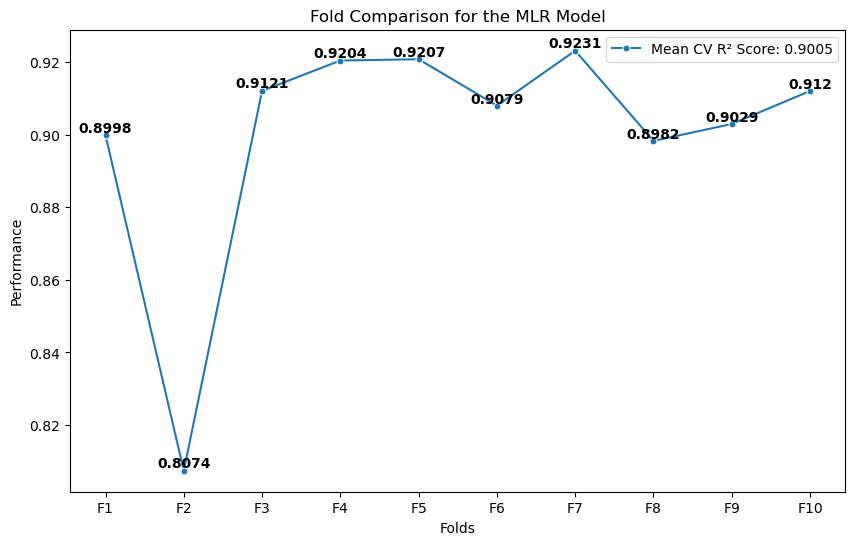

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['lines.markersize'] = 5

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Fold", y="Score", marker="o")
plt.xlabel('Folds')
plt.ylabel('Performance')
plt.title('Fold Comparison for the MLR Model')
plt.legend(markerscale=10)

palette = ['black', 'black', 'black', 'black', 'black','black', 'black', 'black', 'black', 'black']

for line in range(0,df.shape[0]):
     plt.text(df.Fold[line], df.mark_value[line], df.mark_value[line], horizontalalignment='center', verticalalignment ='bottom', size='medium', color='black', weight='semibold')

plt.legend(labels=['Mean CV R² Score: 0.9005'])
plt.show()

In [18]:
coefficients.sort_values(by=['Coefficients']) sequential feature selector, choose only numeric 

SyntaxError: invalid syntax (1975076027.py, line 1)

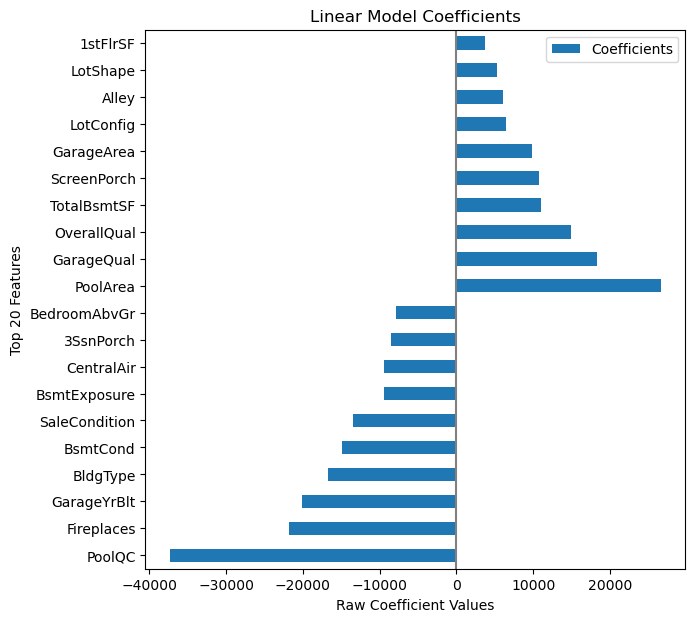

In [19]:
df3 = coefficients[(coefficients['Feature'].isin(['PoolQC', 'Fireplaces', 'GarageYrBlt', 'BldgType', 'BsmtCond', 'SaleCondition', 'BsmtExposure', 'CentralAir', '3SsnPorch', 'BedroomAbvGr',
'PoolArea', 'GarageQual', 'OverallQual', 'TotalBsmtSF', 'ScreenPorch', 'GarageArea', 'LotConfig', 'Alley', 'LotShape', '1stFlrSF'])) & 
(coefficients['Coefficients'].isin([-37303.811625, -21779.724462, -20062.701358, -16752.470497, -14940.573720, -13520.045593, -9440.050825, -9425.020315, -8509.284456, -7918.479813,
26622.696456, 18317.742088, 14966.057559, 11041.925374, 10767.094502, 9863.081129, 6401.245881,6003.032397, 5280.652337, 3775.118436]))]


df3 = [['PoolQC', -37303.811625], 
        ['Fireplaces', -21779.724462], 
        ['GarageYrBlt', -20062.701358], 
        ['BldgType', -16752.470497], 
        ['BsmtCond', -14940.573720],
        ['SaleCondition', -13520.045593], 
        ['BsmtExposure', -9440.050825], 
        ['CentralAir', -9425.020315], 
        ['3SsnPorch', -8509.284456], 
        ['BedroomAbvGr', -7918.479813],
        ['PoolArea', 26622.696456], 
        ['GarageQual', 18317.742088], 
        ['OverallQual', 14966.057559], 
        ['TotalBsmtSF', 11041.925374], 
        ['ScreenPorch', 10767.094502],
        ['GarageArea', 9863.081129], 
        ['LotConfig', 6401.245881], 
        ['Alley', 6003.032397], 
        ['LotShape', 5280.652337], 
        ['1stFlrSF', 3775.118436]]
df3 = pd.DataFrame(df3, columns=['Feature', 'Coefficients'])
df3.plot.barh(x= 'Feature', y = 'Coefficients', figsize=(9, 7))
plt.title("Linear Model Coefficients")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw Coefficient Values")
plt.ylabel("Top 20 Features")
plt.subplots_adjust(left=0.3)

In [35]:
import statsmodels.api as sm
x = sm.add_constant(transformed_df)
y = list(Ames['SalePrice'])
model= sm.OLS(y, x)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])
results = model.fit()
results.model.data.xnames = ['const'] + all_feature_names
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     61.90
Date:                Sun, 11 Aug 2024   Prob (F-statistic):               0.00
Time:                        18:04:14   Log-Likelihood:                -28921.
No. Observations:                2580   AIC:                         5.894e+04
Df Residuals:                    2033   BIC:                         6.214e+04
Df Model:                         546                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           1.29e+05   7.42e+04      1.739